# Compare now-cast performance between our model and NobBS

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import properscoring as ps
import seaborn as sns

sns.set_style("whitegrid")

In [2]:
import matplotlib
plt.rc("text", usetex=False)
plt.rc("font", family="serif")

In [3]:
def get_truth(ltla, report_date="2020-12-14", n=14):
    """
    Get the true count to compare the now-casts against.
    """
    df = pd.read_csv(f"../data/cases-{report_date}.csv"
                ).query(f"`Area name` == '{ltla}' & `Area type` == 'ltla'")
    df = df.sort_values('Specimen date')
    ys_sequence = df['Daily lab-confirmed cases'].values[-14:]

    df = pd.read_csv(f'../data/cases-2020-12-21.csv')
    df = df[(df['Area type']=='ltla')&(df['Specimen date']>='2020-10-09')&(df['Specimen date']<report_date)]
    df['Specimen date'] = pd.to_datetime(df['Specimen date'])
    df = df.sort_values("Specimen date")
    ltla_df = df[(df['Area name']==ltla)&(df['Specimen date']<report_date)]
    truth = ltla_df[-n:]['Daily lab-confirmed cases'].values
    return truth

In [4]:
%cd ..

/Users/rjersakova/Documents/turing-rss/jbc-turing-rss-nowcasting


In [5]:
from models.utils import empirical_credint
from models.inference import Nowcaster

In [6]:
%cd experiments

/Users/rjersakova/Documents/turing-rss/jbc-turing-rss-nowcasting/experiments


In [7]:
df = pd.read_csv(f"../data/cases-2020-12-14.csv")
all_ltlas = list(df.query("`Area type` == 'ltla'")['Area name'].unique())
all_ltlas.remove("King's Lynn and West Norfolk")
all_ltlas.remove("Kingston upon Hull, City of")
all_ltlas.remove("Eden")

Compute absolute errors and CRPS for both models.

In [9]:
our_errors_all = []
nobbs_errors_all = []

our_crps_all = []
nobbs_crps_all = []

for ltla in all_ltlas:

    truth = get_truth(ltla, n=18)

    # original model
    path = f"../experiments/results/2020-12-14/{ltla.replace(' ', '_')}.pickle"
    model = pickle.load(open(path, 'rb'))
    our_samples = np.array(model.x_smoothing_samples[-18:])
    our_nowcast = our_samples.mean(axis=1)

    # nobbs_nowcast
    nobbs_df = pd.read_csv(f"nobbs_results/{ltla}_2020-12-14_stan.csv")
    nobbs_samples = nobbs_df[[f"sum_n_predict.{i}" for i in range(1,19)]].T.to_numpy()
    nobbs_nowcast = nobbs_samples.mean(axis=1)

    # ABSOLUTE ERRORS
    our_errors = np.abs(truth - our_nowcast)[-4:]
    nobbs_errors = np.abs(truth - nobbs_nowcast)[-4:]
    
    our_errors_all.append(our_errors)
    nobbs_errors_all.append(nobbs_errors)
    
    # CRPS
    our_crps = [ps.crps_ensemble(truth[idx], x) for idx,x in enumerate(our_samples)][-4:]
    nobbs_crps = [ps.crps_ensemble(truth[idx], x) for idx,x in enumerate(nobbs_samples)][-4:]
    
    our_crps_all.append(our_crps)
    nobbs_crps_all.append(nobbs_crps)

In [14]:
plt.rc("text", usetex=False)
plt.rc("font", family="serif")

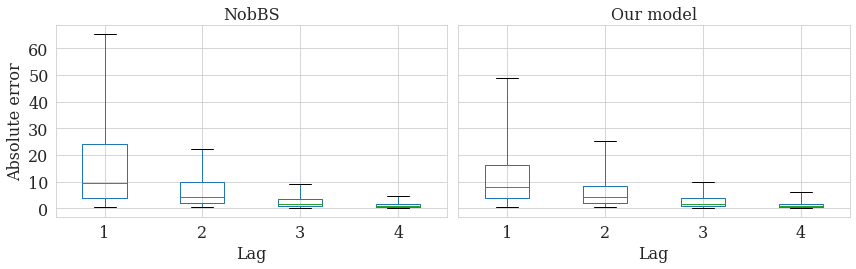

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

pd.DataFrame(np.flip(np.array(our_errors_all))).boxplot(showfliers=False, whis=(5,95), ax=ax[1])
pd.DataFrame(np.flip(np.array(nobbs_errors_all))).boxplot(showfliers=False, whis=(5,95), ax=ax[0])

for i in range(2):

    ax[i].set_xticklabels([1,2,3, 4])
    ax[i].set_xlabel("Lag", fontsize=16)
    plt.setp(ax[i].get_xticklabels(), fontsize=16)
    plt.setp(ax[i].get_yticklabels(), fontsize=16)

ax[1].set_title("Our model", fontsize=16)
# ax[1].set_title("Sigma with prior", fontsize=16)
ax[0].set_title("NobBS", fontsize=16)

ax[0].set_ylabel("Absolute error", fontsize=16)

plt.suptitle("")
plt.tight_layout()
plt.savefig(f"comparison_results.pdf", dpi=600)

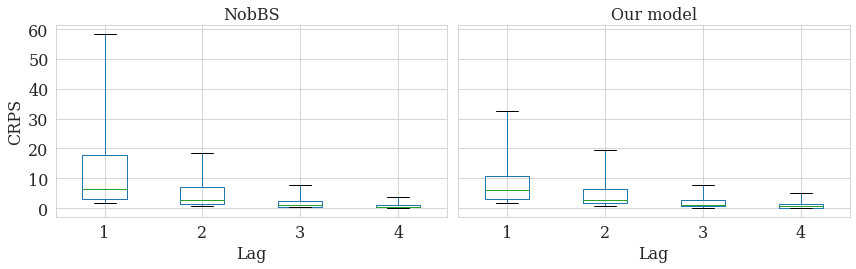

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

pd.DataFrame(np.flip(np.array(our_crps_all))).boxplot(showfliers=False, whis=(5,95), ax=ax[1])
pd.DataFrame(np.flip(np.array(nobbs_crps_all))).boxplot(showfliers=False, whis=(5,95), ax=ax[0])

for i in range(2):

    ax[i].set_xticklabels([1,2,3,4])
    ax[i].set_xlabel("Lag", fontsize=16)
    plt.setp(ax[i].get_xticklabels(), fontsize=16)
    plt.setp(ax[i].get_yticklabels(), fontsize=16)

ax[1].set_title("Our model", fontsize=16)
# ax[1].set_title("Sigma with prior", fontsize=16)
ax[0].set_title("NobBS", fontsize=16)

ax[0].set_ylabel("CRPS", fontsize=16)

plt.suptitle("")
plt.tight_layout()
plt.savefig(f"comparison_results_crps.pdf", dpi=600)